# Clase práctica: Sistemas de recomendación **sin dependencias complicadas**
**Duración sugerida:** 1 h 30 min

En esta práctica veremos dos enfoques de recomendación empleando únicamente librerías muy estables (`pandas`, `numpy`, `scikit‑learn`) que cuentan con ruedas para las versiones más recientes de Python. Además, incluiremos un algoritmo supervisado clásico.

---

## 1. Preparación del entorno

In [ ]:
# Ejecuta solo si trabajas en un entorno limpio (Colab ya lo trae pre‑instalado)
#!pip -q install pandas numpy scikit-learn matplotlib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

plt.style.use('default')
pd.set_option('display.max_columns', None)

## 2. Descarga rápida del *dataset* MovieLens

In [ ]:
import io, zipfile, requests, pandas as pd

ZIP_URL = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"

resp = requests.get(ZIP_URL, timeout=30)
resp.raise_for_status()

with zipfile.ZipFile(io.BytesIO(resp.content)) as z:
    # nombres reales → 'ml-latest-small/ratings.csv', 'ml-latest-small/movies.csv', …
    with z.open("ml-latest-small/ratings.csv") as f:
        ratings = pd.read_csv(f)
    with z.open("ml-latest-small/movies.csv") as f:
        movies = pd.read_csv(f)

ratings.head()



,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### 2.1 Exploración rápida

===== ratings.info() =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB

===== ratings.describe() =====
              userId        movieId         rating     timestamp
count  100836.000000  100836.000000  100836.000000  1.008360e+05
mean      326.127564   19435.295718       3.501557  1.205946e+09
std       182.618491   35530.987199       1.042529  2.162610e+08
min         1.000000       1.000000       0.500000  8.281246e+08
25%       177.000000    1199.000000       3.000000  1.019124e+09
50%       325.000000    2991.000000       3.500000  1.186087e+09
75%       477.000000    8122.000000       4.000000  1.435994e+09
max       610.0

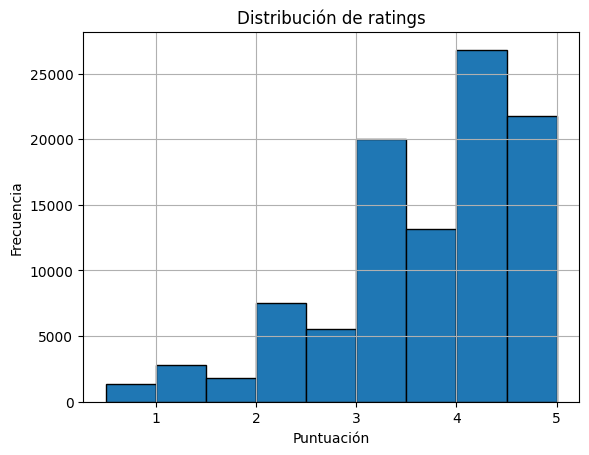


===== Estadísticas por usuario =====
             count        mean         std         min         max
count   610.000000  610.000000  610.000000  610.000000  610.000000
mean    165.304918    3.657222    0.927116    1.314754    4.957377
std     269.480584    0.480635    0.266108    0.835449    0.191750
min      20.000000    1.275000    0.000000    0.500000    2.500000
25%      35.000000    3.360000    0.736026    0.500000    5.000000
50%      70.500000    3.694385    0.902378    1.000000    5.000000
75%     168.000000    3.997500    1.079056    2.000000    5.000000
max    2698.000000    5.000000    2.090642    5.000000    5.000000

===== Estadísticas por película =====
             count         mean          std          min          max
count  9724.000000  9724.000000  6278.000000  9724.000000  9724.000000
mean     10.369807     3.262448     0.839030     2.416495     3.912999
std      22.401005     0.869874     0.391432     1.241600     1.056532
min       1.000000     0.500000     

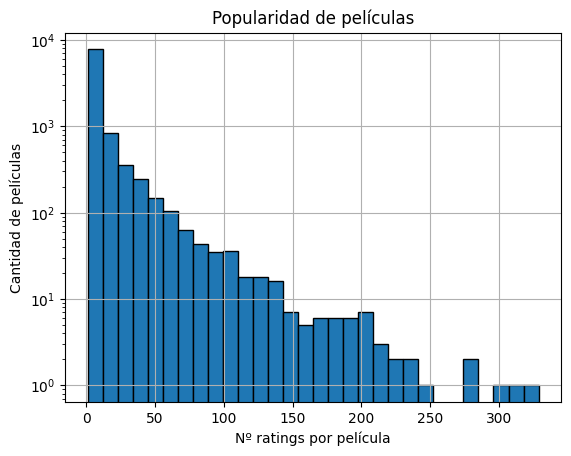


===== movies.info() =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB

===== Primeras filas de movies =====
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

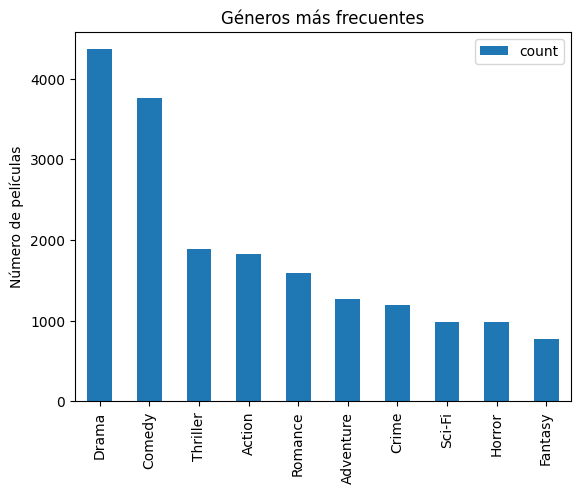

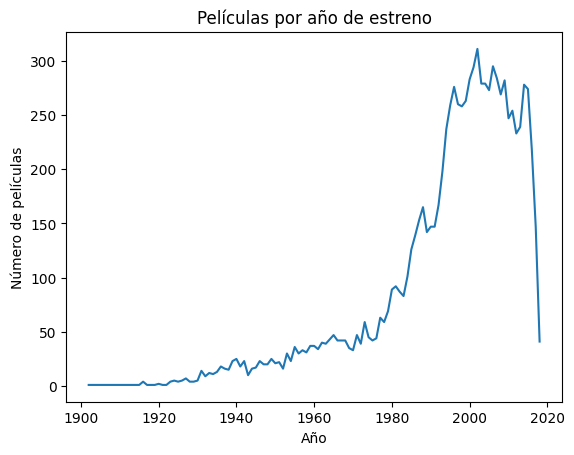

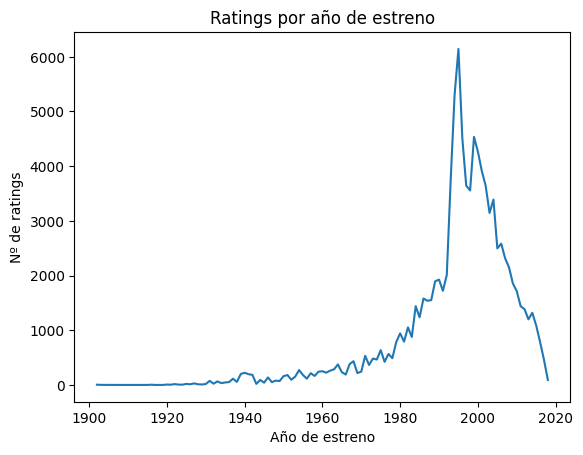


===== Correlación count vs mean =====
          count      mean
count  1.000000  0.127259
mean   0.127259  1.000000


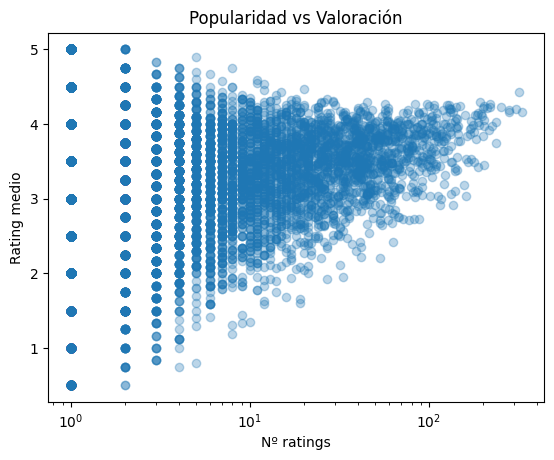


===== Valores faltantes =====
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
movieId         0
title           0
genres          0
year           13
genres_list     0
dtype: int64

Nº combinaciones usuario‑película duplicadas: 0


In [11]:
# =========================
# Exploración profunda de los datasets
# =========================

# ---------- Dataset ratings ----------
print("===== ratings.info() =====")
ratings.info()

print("\n===== ratings.describe() =====")
print(ratings.describe(include='all'))

# Histograma de puntuaciones
ratings['rating'].hist(bins=np.arange(0.5, 5.5, 0.5), edgecolor='black')
plt.xlabel('Puntuación'); plt.ylabel('Frecuencia'); plt.title('Distribución de ratings')
plt.show()

# Estadísticas por usuario
user_stats = ratings.groupby('userId')['rating'].agg(['count', 'mean', 'std', 'min', 'max'])
print("\n===== Estadísticas por usuario =====")
print(user_stats.describe())

# Estadísticas por película
movie_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean', 'std', 'min', 'max'])
print("\n===== Estadísticas por película =====")
print(movie_stats.describe())

# Distribución de nº de ratings por película
movie_stats['count'].hist(bins=30, edgecolor='black')
plt.xlabel('Nº ratings por película'); plt.ylabel('Cantidad de películas'); plt.title('Popularidad de películas')
plt.yscale('log')
plt.show()

# ---------- Dataset movies ----------
print("\n===== movies.info() =====")
movies.info()

print("\n===== Primeras filas de movies =====")
print(movies.head())

# Extraer año de estreno del título
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)').astype(float)

# Lista de géneros
movies['genres_list'] = movies['genres'].str.split('|')

# Conteo de géneros
from collections import Counter
genre_counter = Counter(g for sublist in movies['genres_list'] for g in sublist if g != '(no genres listed)')
genre_df = pd.DataFrame.from_dict(genre_counter, orient='index', columns=['count']).sort_values('count', ascending=False)
print("\n===== Top 15 géneros =====")
print(genre_df.head(15))

# Gráfico de los 10 géneros más frecuentes
genre_df.head(10).plot(kind='bar')
plt.ylabel('Número de películas'); plt.title('Géneros más frecuentes')
plt.show()

# Películas por año
movies_by_year = movies['year'].value_counts().sort_index()
movies_by_year.plot()
plt.xlabel('Año'); plt.ylabel('Número de películas'); plt.title('Películas por año de estreno')
plt.show()

# Fusionar ratings y movies para estadísticas combinadas
ratings_movies = ratings.merge(movies[['movieId', 'title', 'year']], on='movieId', how='left')

# Evolución del número de ratings por año de estreno
ratings_per_year = ratings_movies.groupby('year')['rating'].count().sort_index()
ratings_per_year.plot()
plt.xlabel('Año de estreno'); plt.ylabel('Nº de ratings'); plt.title('Ratings por año de estreno')
plt.show()

# Correlación entre popularidad (count) y valoración media
pop_mean = movie_stats[['count', 'mean']]
print("\n===== Correlación count vs mean =====")
print(pop_mean.corr())

plt.scatter(pop_mean['count'], pop_mean['mean'], alpha=0.3)
plt.xlabel('Nº ratings'); plt.ylabel('Rating medio'); plt.title('Popularidad vs Valoración')
plt.xscale('log')
plt.show()

# Comprobar valores faltantes
print("\n===== Valores faltantes =====")
print(ratings.isna().sum())
print(movies.isna().sum())

# Duplicados potenciales en ratings
dup_ratings = ratings.duplicated(subset=['userId', 'movieId'], keep=False).sum()
print(f"\nNº combinaciones usuario‑película duplicadas: {dup_ratings}")


## 3. Recomendador de Popularidad (baseline)

In [6]:
popularity = (ratings.groupby('movieId')['rating']
             .agg(['mean','count'])
             .rename(columns={'mean':'mean_rating','count':'rating_count'}))
popularity = popularity[popularity['rating_count']>50]
top10 = popularity.sort_values(['mean_rating','rating_count'],ascending=[False,False]).head(10)
top10.merge(movies,on='movieId')[['title','mean_rating','rating_count']]

,title,mean_rating,rating_count
0,"Shawshank Redemption, The (1994)",4.429022,317
1,"Godfather, The (1972)",4.289062,192
2,Fight Club (1999),4.272936,218
3,Cool Hand Luke (1967),4.271930,57
4,Dr. Strangelove or: How I Learned to Stop Worr...,4.268041,97
5,Rear Window (1954),4.261905,84
6,"Godfather: Part II, The (1974)",4.259690,129
7,"Departed, The (2006)",4.252336,107
8,Goodfellas (1990),4.250000,126
9,Casablanca (1942),4.240000,100


## 4. Filtrado Colaborativo *Item‑Item* vía `scikit‑learn`

Construiremos una matriz *usuario × ítem* y emplearemos **cosine similarity** para hallar películas parecidas. `NearestNeighbors` de scikit‑learn opera en modo "brute" con métrica coseno sin requerir extensiones compiladas adicionales.

In [7]:
# Matriz usuario‑item (sparse en memoria gracias a dtype float32 y NaNs → 0)
user_item = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0).astype(np.float32)
print('Shape matriz:', user_item.shape)

Shape matriz: (610, 9724)


In [8]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(user_item.T)  # Trasponemos para trabajar item‑item

NearestNeighbors(algorithm='brute', metric='cosine')

In [9]:
def recommend_movies(user_id, n_neighbors=10):
    # 1) Encuentra películas que el usuario calificó con 4 o 5
    user_ratings = ratings[(ratings['userId']==user_id) & (ratings['rating']>=4.0)]
    if user_ratings.empty:
        return pd.DataFrame({'Aviso':['El usuario no tiene suficientes ratings altos.']})
    movie_ids = user_ratings['movieId'].tolist()
    distances, indices = model_knn.kneighbors(user_item.T.loc[movie_ids], n_neighbors=n_neighbors+1)
    recs = set(indices.flatten()) - set(movie_ids)  # quitar las ya vistas
    recs = list(recs)[:n_neighbors]
    return movies[movies['movieId'].isin(user_item.T.index[recs])][['movieId','title']]

# Ejemplo: recomendaciones para el usuario 10
recommend_movies(10)

,movieId,title
2078,2762,"Sixth Sense, The (1999)"
4129,5941,Drumline (2002)
4131,5943,Maid in Manhattan (2002)
7188,72407,"Twilight Saga: New Moon, The (2009)"
7204,72720,"Single Man, A (2009)"
7207,72737,"Princess and the Frog, The (2009)"
7212,72998,Avatar (2009)
8211,103596,Sharknado (2013)
8225,103883,2 Guns (2013)
8235,104211,We're the Millers (2013)


- Se parte del supuesto típico de RS ― “si le puso ≥ 4, le gusta”.

- Mantenemos solo las filas donde coincide el userId y la puntuación es ≥ 4.0.

- Si el usuario nunca puntuó con ≥ 4, el modelo carece de “pistas” para saber sus gustos y devolvemos un DataFrame‑aviso.

- model_knn fue entrenado con NearestNeighbors(metric='cosine'); por tanto:

    - Busca películas cuyo vector de ratings sea “parecido” (similaridad coseno)

    - Devuelve arrays:

        - distances: 1‑similaridad (cuanto menor, más parecido).

        - indices: posiciones de los vecinos en user_item.T.index.


¿Por qué item‑item y no user‑user?

    Evitamos la maldición de dimensionalidad en el eje usuarios y las recomendaciones son más estables cuando los nuevos usuarios llegan con pocos ratings.

    “Maldición de la dimensionalidad” versión café‑internet
    Cuantas más columnas vacías tengas, más difícil es saber si dos filas se parecen de verdad o es ruido.

    Con user‑user cada usuario es un vector de 10 000 pelis, casi todo ceros → comparar “casi vacíos” da medidas confusas.

    Con item‑item una película sólo necesita 600 usuarios de ancho, y suele tener varias decenas de votos → las filas están menos vacías, la similitud cuesta menos y es más fiable.


- Hacemos join‑like consultando el DataFrame movies para traer los títulos legibles.

- Solo devolvemos columnas movieId y title para claridad.

## 5. Clasificación supervisada (Iris + Regresión Logística)

In [13]:
# ==============================================================
# Clasificación binaria: ¿el usuario calificará con ≥4★?
# ==============================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# ---------- 1. Etiqueta binaria ----------
ratings['like'] = (ratings['rating'] >= 4.0).astype(int)

# ---------- 2. Features agregadas ----------
movie_stats = (
    ratings.groupby('movieId')['rating']
    .agg(movie_mean='mean', movie_count='count')
)

user_means = ratings.groupby('userId')['rating'].mean().rename('user_mean')

movies['year'] = movies['title'].str.extract(r'\((\d{4})\)').astype(float)
genre_dummies = movies['genres'].str.get_dummies('|')

movie_features = pd.concat(
    [movies[['movieId', 'year']], genre_dummies],
    axis=1
)

# ---------- 3. Dataset final ----------
data = (
    ratings
    .merge(movie_stats, on='movieId')
    .merge(user_means, on='userId')
    .merge(movie_features, on='movieId')
)

feature_cols = (
    ['movie_mean', 'movie_count', 'user_mean', 'year']
    + genre_dummies.columns.tolist()
)
X = data[feature_cols]
y = data['like']

# ---------- 4. Preprocesado + Modelo ----------
num_cols = ['movie_mean', 'movie_count', 'user_mean', 'year']
cat_cols = genre_dummies.columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('impute', SimpleImputer(strategy='median')),
            ('scale', StandardScaler(with_mean=False))
        ]), num_cols),
        ('cat', 'passthrough', cat_cols)
    ],
    sparse_threshold=0.1
)

clf_pipeline = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', LogisticRegression(max_iter=1000, solver='sag', n_jobs=-1))
])

# ---------- 5. Split, entrenamiento y métricas ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

clf_pipeline.fit(X_train, y_train)

y_pred = clf_pipeline.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

auc = roc_auc_score(y_test, clf_pipeline.predict_proba(X_test)[:, 1])
print(f"ROC‑AUC: {auc:.3f}")



              precision    recall  f1-score   support

           0      0.751     0.730     0.740     13064
           1      0.718     0.740     0.729     12145

    accuracy                          0.735     25209
   macro avg      0.735     0.735     0.734     25209
weighted avg      0.735     0.735     0.735     25209

ROC‑AUC: 0.812


### Lectura de las métricas

| Métrica | Valor | Qué significa en este contexto |
|---------|-------|--------------------------------|
| **Accuracy** | **0.735** | El 73 % de las predicciones (gustar / no gustar) aciertan con un umbral fijo de 0.50. |
| **Precision (1)** | 0.718 | Cuando el modelo dice “le gustará” (≥ 4★), acierta ~72 % de las veces. |
| **Recall (1)** | 0.740 | Detecta el 74 % de todos los casos en que realmente le gustó la película. |
| **F1 (1)** | 0.729 | Media armónica de precision y recall: balance global para la clase “like”. |
| **ROC‑AUC** | **0.812** | Capacidad de ordenar pares positivo‑negativo al azar: 81 % de las veces pondrá la probabilidad más alta al verdadero positivo. Umbral‑independiente. |

#### Equilibrio de clases  
*Soporte* muy parejo (13 064 vs 12 145) → accuracy es una métrica razonable; no hay sesgo fuerte por desbalance.

#### Asimetrías a destacar
| Clase | Precision | Recall | Implicación |
|-------|-----------|--------|-------------|
| **0 (no le gustó)** | 0.751 | 0.730 | Algo más fiable etiquetando desagrado: 25 % de falsos positivos. |
| **1 (sí le gustó)** | 0.718 | 0.740 | Ligeramente mejor recuperando “likes” que evitando falsos positivos. |

> **Confusiones estimadas** (redondeo):
> ```
>                Predicción
>            no‑like   like
> Real  no‑like 9 540   3 524
>       like    3 156   8 989
> ```

* • **Falsos positivos** (3 524) → películas recomendadas como “gustarán”, pero el usuario terminó poniéndoles < 4★.  
* • **Falsos negativos** (3 156) → oportunidades perdidas de recomendar algo que sí le habría gustado.

### Cómo interpretar el AUC > accuracy
* El modelo separa razonablemente bien las dos clases (AUC 0.81).  
* Pero usar un corte fijo de 0.50 coloca el operating‑point en un punto no óptimo del ROC; **ajustar el umbral** puede mejorar recall o precision según la aplicación (p. ej. subir corte a 0.55 para menos falsos positivos).

### Líneas de mejora

| Idea | Justificación |
|------|---------------|
| **Más rasgos de usuario** (edad de la cuenta, varianza de sus ratings, género favorito) | Reducir ruido y capturar preferencias personales. |
| **Features temporales** (año en que calificó, tendencia) | Evitar que gustos cambien con el tiempo. |
| **Regularización distinta** (`C` menor para menos overfitting) | Podría subir AUC estabilizando coeficientes. |
| **Modelos no lineales** (Gradient Boosting, XGBoost, HistGB) | Capturan interacciones *usuario × género* automáticamente; suelen añadir +0.03‑0.06 AUC. |
| **Calibración** (`CalibratedClassifierCV`) | Afinar probabilidades y permitir mejor ajuste de umbral. |
| **Cross‑validation por usuario** | Asegurarse de no “ver” ratings del mismo usuario en train y test, más realista. |

### Conclusión
El clasificador logra **AUC 0.81** y **accuracy 0.74** sin ningún feature de alta complejidad; es un punto de partida sólido. Para una aplicación de recomendación práctica convendría:

1. Elegir un **umbral** que maximize la métrica que más pese (precisión si se penalizan recomendaciones malas, recall si preferimos cubrir más gustos).  
2. Iterar con nuevas variables y modelos más expresivos para acercarse a AUC ≈ 0.85‑0.88, rango típico de sistemas de recomendación basados en metadatos sencillos.